In [31]:
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import *
import numpy as np

### Define variables

In [32]:
DATA_PATH = settings.data_path
DATE_FORMAT = '%Y-%m-%d'
START_DATE = '2016-12-21'
END_DATE = '2021-04-20'
MASK_PATH = "water_mask.json"

### Make instance of data generator

In [33]:
#data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH)

### Load sample day

In [34]:
#sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

### Load water mask

In [35]:
sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

mask_height, mask_width, _ = sample_day.rgb.shape
mask = Mask(MASK_PATH, mask_width, mask_height)
mask.reduce_mask()

print("Pixel count:", mask.get_pixel_count())

100%|██████████| 441288/441288 [00:09<00:00, 46344.11it/s]


Pixel count: 17963


### Display mask in sample day

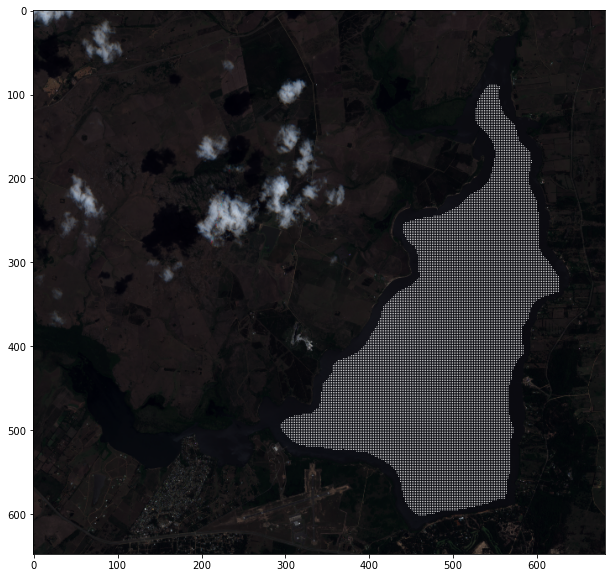

In [36]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mask.display_mask_img(sample_day.rgb))
plt.show()

### Tag valid and invalid data

In [37]:
# from IPython.display import clear_output
# import time

# data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, tagging=True)

# for day in data_generator:
#     print(day.date)
#     print(day.metadata)
#     current_metadata = day.metadata
#     if current_metadata != {}:
#         time.sleep(0.1)
#         clear_output(wait=True)
#         continue
#     # display rgb of day
#     fig = plt.figure(figsize=(20,10))
#     plt.imshow(mask.display_mask_contour(day.rgb))
#     plt.show()
#     # get user input
#     user_input = input()
#     # process input
#     if user_input == "y":
#         status = True
#     elif user_input == "n":
#         status = False
#     else:
#         status = "N/A"
#     # overwrite with changes
#     with open(day.metadata_path, 'w') as fp:
#         current_metadata["valid"] = status
#         json.dump(current_metadata, fp)
#     clear_output(wait=True)

## Clustering

### Make NDCI numpy array dataset

In [38]:
# make instance of data generator that skips invalid dates
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
# make array to store ndci of every valid day
ndci_dataset_array = np.zeros((sample_day.rgb.shape[0], sample_day.rgb.shape[1], len(data_generator)))
# list of dates for ndci_dataset_array
dates_list = []
# progress bar
pbar = tqdm(total=len(data_generator))
for d, day in enumerate(data_generator):
    ndci_day_array = day.get_NDCI()
    dates_list.append(str(day.date.date()))
    ndci_dataset_array[:, :, d] = ndci_day_array
    pbar.update(1)
pbar.close()

100%|██████████| 78/78 [00:04<00:00, 16.34it/s]


### Make clustering dataset

In [39]:
clustering_dataset = []
indexes = []
pbar = tqdm(total=mask.height*mask.width)
for i in range(mask.height):
    for j in range(mask.width):
        if mask.array[i, j] == 255:
            clustering_dataset.append(list(ndci_dataset_array[i, j, :]))
            indexes.append([i, j])
        pbar.update(1)
pbar.close()

100%|██████████| 441288/441288 [00:01<00:00, 341006.57it/s]


### Save to json

In [40]:
clustering_data = {}
clustering_data["data"] = clustering_dataset
clustering_data["positions"] = indexes
clustering_data["dates"] = dates_list

# with open("clustering_dataset_20m.json", 'w') as f:
#     json.dump(json_dictionary, f)

### Load clustering dataset

In [41]:
# import json

# with open("clustering_dataset_20m.json") as f:
#     clustering_data = json.load(f)

# Fit clustering data

In [42]:
X = clustering_data["data"]

### K-means

100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


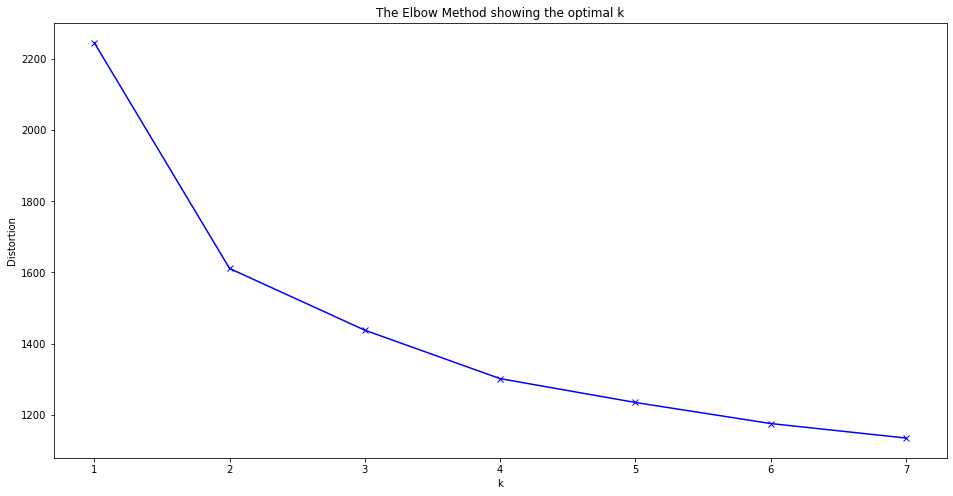

In [43]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,8)
pbar = tqdm(total=7)
for k in K:
    clusteringModel = KMeans(n_clusters=k)
    clusteringModel.fit(X)
    distortions.append(clusteringModel.inertia_)
    pbar.update(1)
pbar.close()

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Agglomerative clustering

In [44]:
linkage_methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]

metrics = ["euclidean", "minkowski", "cityblock", "seuclidean", "sqeuclidean", "cosine", 
           "correlation", "hamming", "jaccard", "chebyshev", "canberra", "braycurtis", 
           "mahalanobis", "yule"]

Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used.

In [ ]:
import scipy.cluster.hierarchy as sch

output_directory = "Agglomerative clustering"
save_matrix = True

for linkage_method in linkage_methods:
    for distance_metric in metrics:
        print("processing " + linkage_method + " linkage method with " + distance_metric + " metric")
        
        if linkage_method in ["centroid", "median", "ward"] and distance_metric != "euclidean":
            continue
        
        agglomerative_clustering_directory = os.path.join(output_directory, linkage_method, distance_metric)
        if not os.path.isdir():
            os.makedirs(agglomerative_clustering_directory)
        
        try:
            linkage_matrix = np.load(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"))
        except FileNotFoundError:
            linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)
            if save_matrix == True:
                np.save("linkage_matrix.npy", )
        
        try:
            dendrogram = sch.dendrogram(, truncate_mode='level', p=5)
            plt.figure(figsize=(16,8))
            plt.title(linkage_method + ' linkage dendrogram')
            plt.xlabel('Number of points in node')
            plt.ylabel(distance_metric + ' distances')
            plt.savefig(results_dir + sample_file_name)
        #plt.show()
        except Exception as e:
            print("Error with", linkage_method, "linkage and", distance_metric, "metric:", str(e))

In [50]:
linkage_to_save = sch.linkage(X, method='ward', metric='euclidean')
np.save("test.npy", linkage_to_save)

loaded_linkage = np.load("test.npy")

print((linkage_to_save == loaded_linkage).all())


True


### Choose clustering algorithm

In [19]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS

#clustering = KMeans(n_clusters=3, random_state=0).fit(X)
clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X)
#clustering = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(X)
#clustering = OPTICS(min_samples=100).fit(X)

### Display clusters

cluster labels: [0, 1, 2, 3, 4, 5]


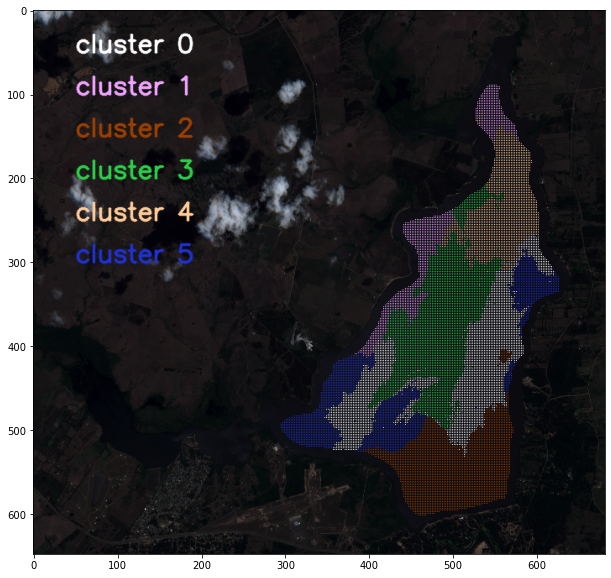

In [20]:
from process_sentinel2 import *
import random
import cv2

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
final_img = sample_day.rgb.copy()
labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254


clusters_colors = [[255,255,255], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [0, 0, 0]]

unique_labels = list(set(clustering.labels_))
print("cluster labels:", unique_labels)

# here I'm iterating over a list containing the label of every pixel in the lagoon
for i, label in enumerate(clustering.labels_):
    if label == -1:
        continue
    label_position = clustering_data["positions"][i]
#     r = random.randint(0, 254)
#     g = random.randint(0, 254)
#     b = random.randint(0, 254)
#     color = [r, g, b]
#     final_img[label_position[0], label_position[1], :] = color
    final_img[label_position[0], label_position[1], :] = clusters_colors[label]
    
    labels_arr[label_position[0], label_position[1]] = int(label)

#draw legends
legend_position = {"x": 50, "y": 50}
for label in unique_labels:
    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
    legend_position["y"] = legend_position["y"] + 50    

fig = plt.figure(figsize=(20,10))
plt.imshow(final_img)
plt.show()

### Get mean and std of every cluster for every day

In [15]:
H, W, D = ndci_dataset_array.shape

results = []

pbar = tqdm(total=D)
for d in range(D):
    day_results = {}
    day_results["date"] = clustering_data["dates"][d]
    day_ndci = ndci_dataset_array[:, :, d]
    
    for label in unique_labels:
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        label_mean = np.mean(label_ndci_values)
        label_std = np.std(label_ndci_values)
        
        day_results[label] = {"mean": label_mean, "std": label_std}
    results.append(day_results)
    pbar.update(1)            
pbar.close()

100%|██████████| 78/78 [00:01<00:00, 52.86it/s]


# Visualization

### Time series of NDCI mean

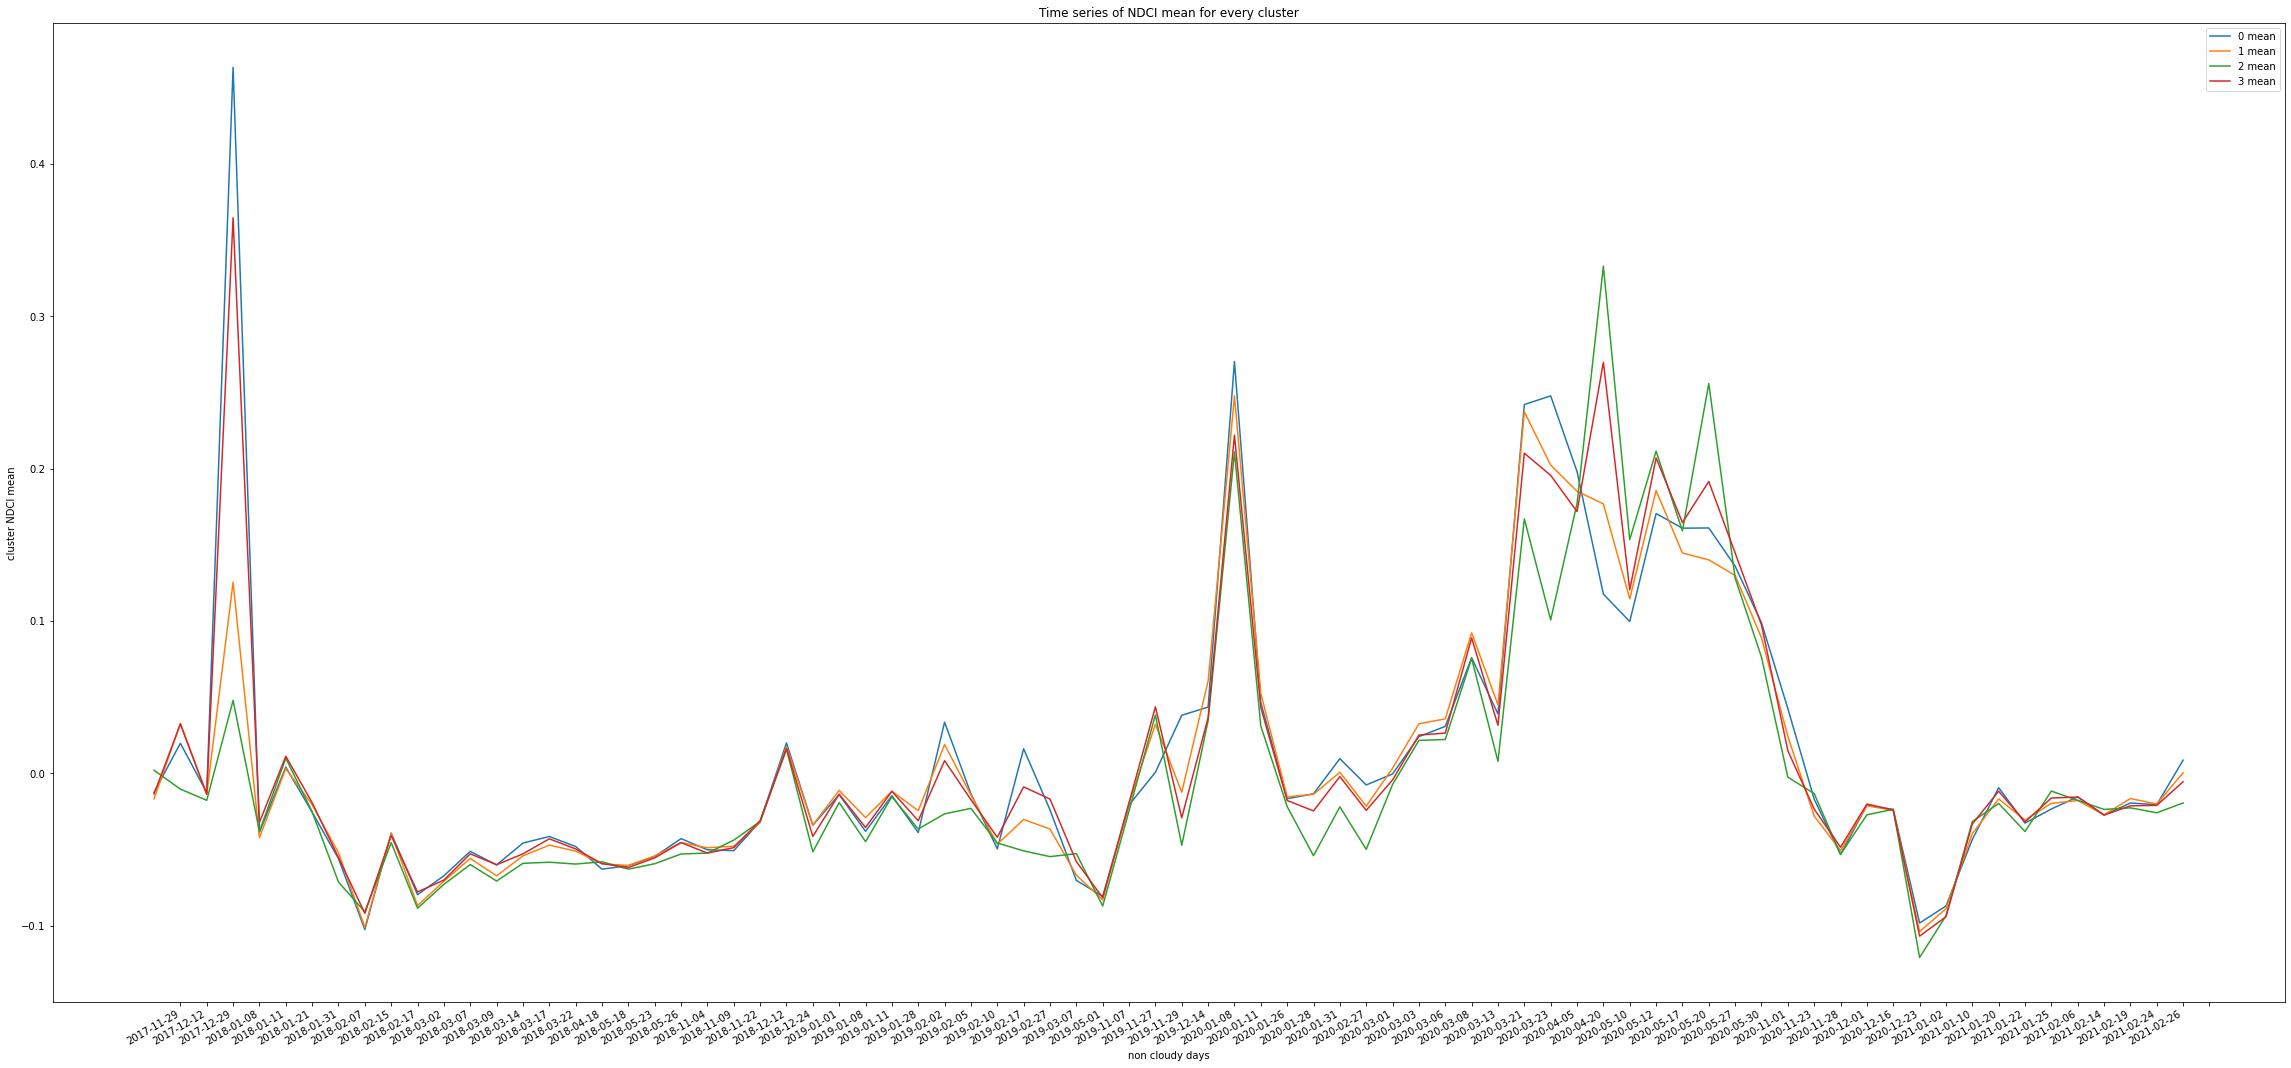

In [16]:
import matplotlib.pyplot as plt

day_indexes = range(1, len(results)+1)
fig = plt.figure(figsize=(40,20))
for label in unique_labels:
    label_means = [d[label]["mean"] for d in results]
    #label_stds = [d[label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    plt.plot([d["date"] for d in results], label_means, label=str(label) + " mean")
    #plt.plot(day_indexes, label_stds, label=str(label) + " std")

plt.xlabel('non cloudy days')
plt.xticks(np.arange(1, len(results)+1, 1.0))
# Set the y axis label of the current axis.
plt.ylabel('cluster NDCI mean')
# Set a title of the current axes.
plt.title('Time series of NDCI mean for every cluster')
# show a legend on the plot
plt.legend()
# Display a figure.
fig.autofmt_xdate()
plt.show()

### Box plot

In [ ]:
import matplotlib.pyplot as plt

H, W, D = ndci_dataset_array.shape

results_box = []

pbar = tqdm(total=D)
for d in range(D):
    day_results = {}
    day_results["date"] = clustering_data["dates"][d]
    day_ndci = ndci_dataset_array[:, :, d]
    for label in unique_labels:
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        day_results[label] = label_ndci_values
    results_box.append(day_results)
    pbar.update(1)            
pbar.close()

for label in unique_labels:
    fig = plt.figure(figsize=(20,10))
    plt.title("Cluster " + str(label))
    boxplot_output = plt.boxplot([day[label] for day in results_box])
    plt.show()

### Visualize rgb from day in particular

2017-12-29


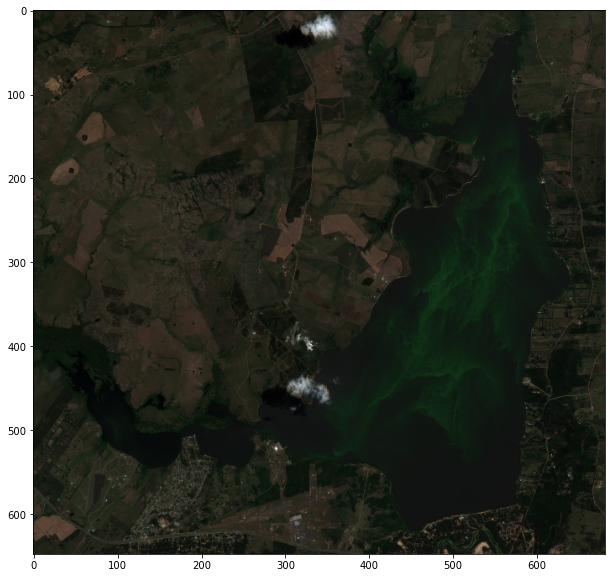

In [82]:
#DATE = "2021-01-25"
DATE = results[3]["date"]
print(DATE)

day_data = DayData(os.path.join(settings.data_path, DATE, "acolite_output"))
fig = plt.figure(figsize=(20,10))
plt.imshow(day_data.rgb)
plt.show()